In [1]:
from TrackedTractorENV import TractorEnv
from SGDSAC import NoveltyReward
from SGDSAC import Monitor
from SGDSAC import Logger
from SGDSAC import LoggerVisualizer
from SGDSAC import ReplayBuffer
from SGDSAC import GDSAC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Training

### Random seeds and devices

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Logger configuration

In [3]:
log_dir = f'./log/seed{seed}'
output_excel = f'training_logs_seed{seed}.xlsx'
frequency = 500
Logger = Logger(log_dir,frequency)
visualizer = LoggerVisualizer(log_dir,output_excel)

### Environment configuration

In [4]:
env = TractorEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
min_action = -max_action
max_episode_steps = env.model.TotalStep

### Agent configuration

In [5]:
kwargs = {
    "state_dim": state_dim, # State dimension
    "action_dim": action_dim, # Action dimension
    "max_action": max_action, # Maximum action
    "device": device, # "CPU" or "GPU"
    "Logger": Logger, # logger
    "use_actor_tag": True, # Use the target actor network?
    "Qcritic_3sig": True, # Does the reward critic network use the 3 sigma principle?
    "hidden_width": [400,300,200], # Network nodes
    "batch_size": 100, # Batch size
    "GAMMA": 0.99, # Discount factor
    "TAU": 0.005, # Target network update rate
    "alphalr": 5e-5, # Alpha learning rate
    "qlr": 5e-5, # Reward critic learning rate
    "alr": 5e-5, # Actor learning rate
    "tau_b": 0.1, # Sliding sigma update rate
    "policy_freq": 2, # Frequency of delayed policy updates
    "ubc_fac": 0.08, # UBC factor
    }
agent = GDSAC(**kwargs)
replay_buffer = ReplayBuffer(state_dim, action_dim, device)
Novelty = NoveltyReward(state_dim, 5, learning_rate=0.001)

cuda
Actor(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=200, bias=True)
  )
  (mean_layer): Linear(in_features=200, out_features=1, bias=True)
  (log_std_layer): Linear(in_features=200, out_features=1, bias=True)
)
Critic(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=200, bias=True)
  )
  (mean): Linear(in_features=200, out_features=1, bias=True)
  (log_var): Linear(in_features=200, out_features=1, bias=True)
)
Critic(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=200, bias=True)
  )
  (mean): Linear(in_features=200, out_features=1, bias=True)
  (log_va

### Security monitor configuration

In [6]:
X_upper = 0.845
X_lower = 0.355
lammax = 0.00005
kmax = 8
lammin = 10
kmin = 10
QP = Monitor(env,min_action,max_action,X_upper,X_lower,lammax,kmax,lammin,kmin)

### Training loop

In [7]:
max_train_steps = 1000
random_steps = 5

for t in range(int(max_train_steps)):
    s, done = env.reset(), False
    episode_reward = 0.0
    episode_cost = 0.0

    while not done:
        if t <= random_steps:
            org_a = (max_action - min_action) * np.random.random(env.action_space.shape) + min_action
        else:
            org_a = agent.choose_action(s)

        a, u_opt, is_safe, phi = QP.solve_qp(org_a, env)

        s_, r, c, done, _ = env.step(a)

        state_tensor = torch.FloatTensor(s).to(device)
        r_ = Novelty.get_novelty_score(state_tensor)

        if is_safe:
            replay_buffer.add(s, org_a, r+r_, c, s_, float(done))

        s = s_
        episode_reward += r
        episode_cost += c

        if t > random_steps:
            agent.learn(replay_buffer)

        if done:
            Novelty.train(replay_buffer, num_epochs=6, batch_size1=600, batch_size2=100)

            print("episode:", t,
                  "| SoC: %.3f" % s[2],
                  "| reward: %.3f" % episode_reward,
                  "| cost: %.3f" % episode_cost)

            Logger.log_reward(episode_reward, episode_cost, s[2])
Logger.close()
visualizer.save_to_excel()

episode: 0 | SoC: 0.441 | reward: -382450.616 | cost: 0.000
episode: 1 | SoC: 0.624 | reward: -148403.635 | cost: 0.000
episode: 2 | SoC: 0.700 | reward: -379469.999 | cost: 0.000
episode: 3 | SoC: 0.551 | reward: -167208.330 | cost: 0.000
episode: 4 | SoC: 0.568 | reward: -224981.855 | cost: 0.000
episode: 5 | SoC: 0.394 | reward: -369785.807 | cost: 0.000
episode: 6 | SoC: 0.486 | reward: -79449.588 | cost: 0.000
episode: 7 | SoC: 0.359 | reward: -675090.124 | cost: 0.000
episode: 8 | SoC: 0.357 | reward: -676102.704 | cost: 0.000
episode: 9 | SoC: 0.356 | reward: -679961.382 | cost: 0.000
episode: 10 | SoC: 0.360 | reward: -679318.914 | cost: 0.000
episode: 11 | SoC: 0.360 | reward: -669514.241 | cost: 0.000
episode: 12 | SoC: 0.360 | reward: -666740.013 | cost: 0.000
episode: 13 | SoC: 0.360 | reward: -666736.659 | cost: 0.000
episode: 14 | SoC: 0.360 | reward: -672269.652 | cost: 0.000
episode: 15 | SoC: 0.359 | reward: -675751.916 | cost: 0.000
episode: 16 | SoC: 0.440 | reward: 

# Results display

### Data loading

In [8]:
file_path = 'training_logs_seed0.xlsx'
train_log = pd.read_excel(file_path, sheet_name="Reward")
actor_log = pd.read_excel(file_path, sheet_name="Actor")
critic_log = pd.read_excel(file_path, sheet_name="Critic")

In [9]:
Step_train_log = train_log['Step']
Episode_Reward = train_log['reward']
Episode_Cost = train_log['cost']
Final_SoC = train_log['SoC']
Step_actor_log = actor_log['Step']
Actor_loss = actor_log['actor']
Step_critic_log = critic_log['Step']
Critic1_loss = critic_log['reward_critic1']
Critic2_loss = critic_log['reward_critic2']
Critic1_Qloss = critic_log['reward_critic1_Q']
Critic2_Qloss = critic_log['reward_critic2_Q']
Critic1_Vloss = critic_log['reward_critic1_V']
Critic2_Vloss = critic_log['reward_critic2_V']

In [10]:
def smooth_curve(data, weight=0.6):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

In [11]:
colors = ['#FF5E5E', '#00A1CB', '#FABE28', '#2B3E51', '#8A2BE2', '#FFC300', '#76D7EA']
idx = 6

### Episode reward, episode cost and final SoC

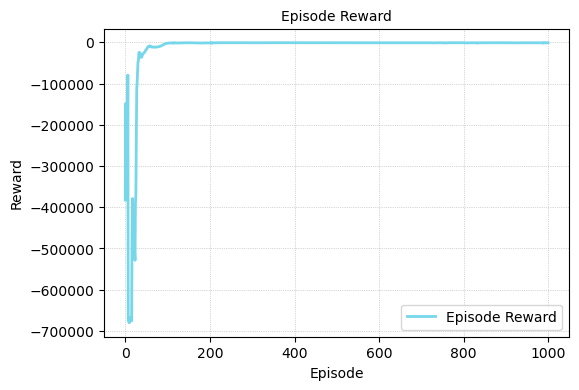

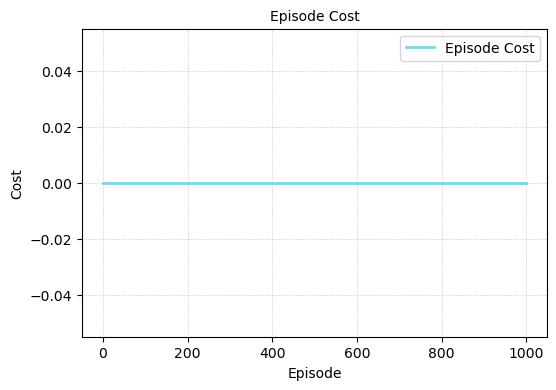

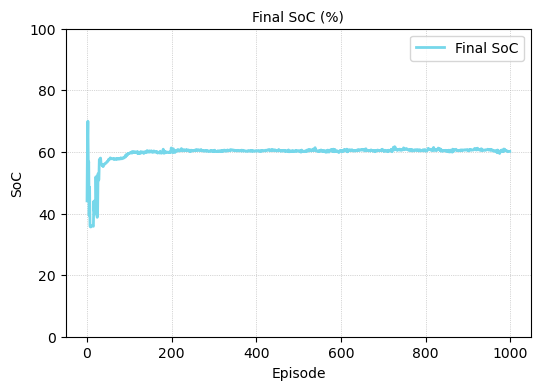

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(Step_train_log, Episode_Reward, label='Episode Reward', color=colors[idx], linewidth=2, antialiased=True)
plt.title('Episode Reward', fontsize=10)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('Reward', fontsize=10)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(Step_train_log, Episode_Cost, label='Episode Cost', color=colors[idx], linewidth=2, antialiased=True)
plt.title('Episode Cost', fontsize=10)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('Cost', fontsize=10)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(Step_train_log, Final_SoC * 100, label='Final SoC', color=colors[idx], linewidth=2, antialiased=True)
plt.title('Final SoC (%)', fontsize=10)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('SoC', fontsize=10)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 100)
plt.show()

### Actor loss and critic loss

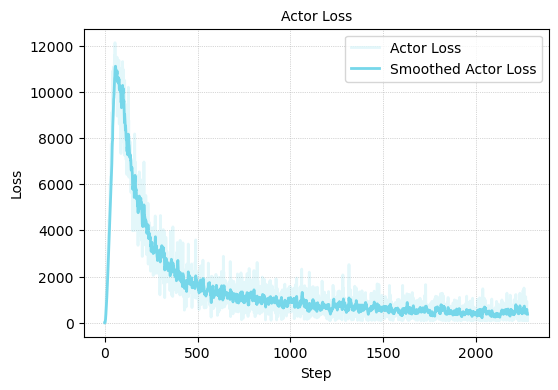

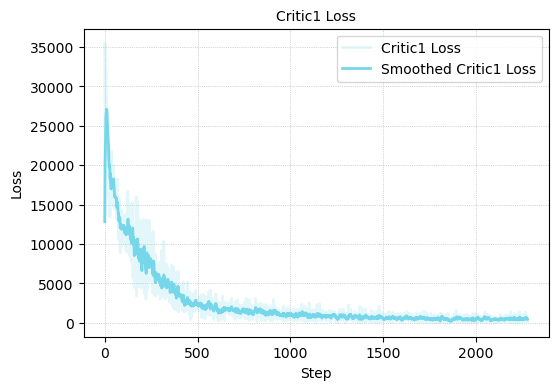

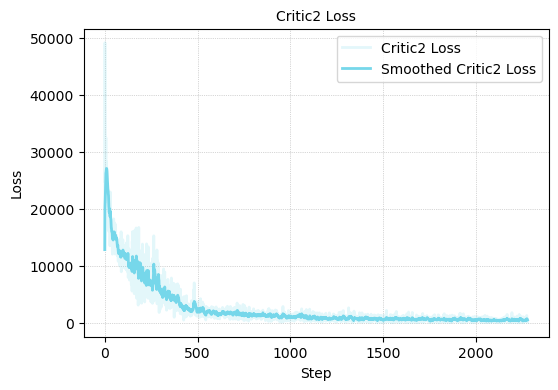

In [13]:
smooth_actor_loss = smooth_curve(Actor_loss, weight=0.8)
plt.figure(figsize=(6, 4))
plt.plot(Step_actor_log, Actor_loss, label='Actor Loss', color=colors[idx], linewidth=2, antialiased=True, alpha=0.2)
plt.plot(Step_actor_log, smooth_actor_loss, label='Smoothed Actor Loss', color=colors[idx], linewidth=2)
plt.title('Actor Loss', fontsize=10)
plt.xlabel('Step', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

smooth_Critic1_loss = smooth_curve(Critic1_loss, weight=0.8)
plt.figure(figsize=(6, 4))
plt.plot(Step_critic_log, Critic1_loss, label='Critic1 Loss', color=colors[idx], linewidth=2, antialiased=True, alpha=0.2)
plt.plot(Step_critic_log, smooth_Critic1_loss, label='Smoothed Critic1 Loss', color=colors[idx], linewidth=2)
plt.title('Critic1 Loss', fontsize=10)
plt.xlabel('Step', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

smooth_Critic2_loss = smooth_curve(Critic2_loss, weight=0.8)
plt.figure(figsize=(6, 4))
plt.plot(Step_critic_log, Critic2_loss, label='Critic2 Loss', color=colors[idx], linewidth=2, antialiased=True, alpha=0.2)
plt.plot(Step_critic_log, smooth_Critic2_loss, label='Smoothed Critic2 Loss', color=colors[idx], linewidth=2)
plt.title('Critic2 Loss', fontsize=10)
plt.xlabel('Step', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()